# Face Detection and Anonymization System

This notebook implements a computer vision system for detecting faces in images and anonymizing them using face swapping techniques.

## Table of Contents
1. [Setup and Imports](#setup)
2. [Face Detection](#detection)
3. [Face Landmark Detection](#landmarks)
4. [Face Swapping](#swapping)
5. [Testing and Evaluation](#testing)

## 1. Setup and Imports <a name="setup"></a>

First, let's install and import all necessary libraries for our face detection and anonymization system.

In [9]:
# Install required packages (compatible with Python 3.13)
!pip install opencv-python opencv-contrib-python
!pip install numpy matplotlib
!pip install Pillow
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [10]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from typing import List, Tuple, Optional
from scipy.spatial import Delaunay

# Set matplotlib to display images inline
%matplotlib inline

# Set up plot style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ All libraries imported successfully!")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Python version: 3.13.9 (using OpenCV-only solution)")

✓ All libraries imported successfully!
OpenCV version: 4.12.0
NumPy version: 2.2.6
Python version: 3.13.9 (using OpenCV-only solution)


### Helper Functions for Visualization

Let's create some utility functions to display images properly in the notebook.

In [11]:
def display_image(image, title="Image", cmap=None, figsize=(10, 6)):
    """
    Display an image using matplotlib.
    
    Args:
        image: Image array (BGR or RGB)
        title: Title for the plot
        cmap: Color map (None for RGB, 'gray' for grayscale)
        figsize: Figure size tuple
    """
    plt.figure(figsize=figsize)
    if len(image.shape) == 3 and image.shape[2] == 3:
        # Convert BGR to RGB for display
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image, cmap=cmap)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def display_images_grid(images, titles, rows=1, cols=2, figsize=(15, 8)):
    """
    Display multiple images in a grid.
    
    Args:
        images: List of images
        titles: List of titles
        rows: Number of rows
        cols: Number of columns
        figsize: Figure size tuple
    """
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if rows * cols > 1 else [axes]
    
    for idx, (image, title) in enumerate(zip(images, titles)):
        if idx < len(axes):
            if len(image.shape) == 3 and image.shape[2] == 3:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(image)
            axes[idx].set_title(title, fontsize=12, fontweight='bold')
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

print("✓ Visualization functions defined!")

✓ Visualization functions defined!


## 2. Face Detection <a name="detection"></a>

We'll implement face detection using multiple methods:
- Haar Cascade (OpenCV)
- DNN-based face detector (more accurate)

### 2.1 Haar Cascade Face Detection

In [12]:
class FaceDetector:
    """
    A class for detecting faces in images using various methods.
    """
    
    def __init__(self, method='haar'):
        """
        Initialize the face detector.
        
        Args:
            method: Detection method ('haar' or 'dnn')
        """
        self.method = method
        
        if method == 'haar':
            # Load Haar Cascade classifier
            self.face_cascade = cv2.CascadeClassifier(
                cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
            )
            print("✓ Haar Cascade loaded")
            
        elif method == 'dnn':
            # Load DNN model for face detection
            self.model_file = "res10_300x300_ssd_iter_140000.caffemodel"
            self.config_file = "deploy.prototxt"
            
            # Note: You'll need to download these files
            # We'll provide download instructions
            try:
                self.net = cv2.dnn.readNetFromCaffe(self.config_file, self.model_file)
                print("✓ DNN model loaded")
            except:
                print("⚠ DNN model files not found. Using Haar Cascade instead.")
                self.method = 'haar'
                self.face_cascade = cv2.CascadeClassifier(
                    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
                )
    
    def detect_faces_haar(self, image, scale_factor=1.1, min_neighbors=5, min_size=(30, 30)):
        """
        Detect faces using Haar Cascade.
        
        Args:
            image: Input image (BGR)
            scale_factor: Parameter specifying how much the image size is reduced at each image scale
            min_neighbors: Parameter specifying how many neighbors each candidate rectangle should have
            min_size: Minimum possible object size
            
        Returns:
            List of face bounding boxes [(x, y, w, h), ...]
        """
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Detect faces
        faces = self.face_cascade.detectMultiScale(
            gray,
            scaleFactor=scale_factor,
            minNeighbors=min_neighbors,
            minSize=min_size
        )
        
        return faces
    
    def detect_faces_dnn(self, image, confidence_threshold=0.5):
        """
        Detect faces using DNN model.
        
        Args:
            image: Input image (BGR)
            confidence_threshold: Minimum confidence for detection
            
        Returns:
            List of face bounding boxes [(x, y, w, h), ...]
        """
        h, w = image.shape[:2]
        
        # Prepare blob for DNN
        blob = cv2.dnn.blobFromImage(
            cv2.resize(image, (300, 300)),
            1.0,
            (300, 300),
            (104.0, 177.0, 123.0)
        )
        
        # Forward pass
        self.net.setInput(blob)
        detections = self.net.forward()
        
        # Extract faces with high confidence
        faces = []
        for i in range(detections.shape[2]):
            confidence = detections[0, 0, i, 2]
            
            if confidence > confidence_threshold:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (x, y, x2, y2) = box.astype("int")
                faces.append((x, y, x2-x, y2-y))
        
        return np.array(faces)
    
    def detect(self, image, **kwargs):
        """
        Detect faces using the selected method.
        
        Args:
            image: Input image (BGR)
            **kwargs: Additional parameters for the detection method
            
        Returns:
            List of face bounding boxes
        """
        if self.method == 'haar':
            return self.detect_faces_haar(image, **kwargs)
        elif self.method == 'dnn':
            return self.detect_faces_dnn(image, **kwargs)
    
    def draw_faces(self, image, faces, color=(0, 255, 0), thickness=2):
        """
        Draw bounding boxes around detected faces.
        
        Args:
            image: Input image
            faces: List of face bounding boxes
            color: Rectangle color (BGR)
            thickness: Rectangle thickness
            
        Returns:
            Image with drawn rectangles
        """
        result = image.copy()
        
        for (x, y, w, h) in faces:
            cv2.rectangle(result, (x, y), (x+w, y+h), color, thickness)
            # Add label
            cv2.putText(result, 'Face', (x, y-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        return result

print("✓ FaceDetector class defined!")

✓ FaceDetector class defined!


### 2.2 Test Face Detection

Let's test the face detector with a sample image.

In [13]:
# Initialize the face detector
detector = FaceDetector(method='haar')

# For testing, let's create a simple test or load an image
# You can replace this with your own image path
print("Face detector initialized!")
print("To test, load an image using: image = cv2.imread('path/to/your/image.jpg')")

✓ Haar Cascade loaded
Face detector initialized!
To test, load an image using: image = cv2.imread('path/to/your/image.jpg')


Found 1 face(s)


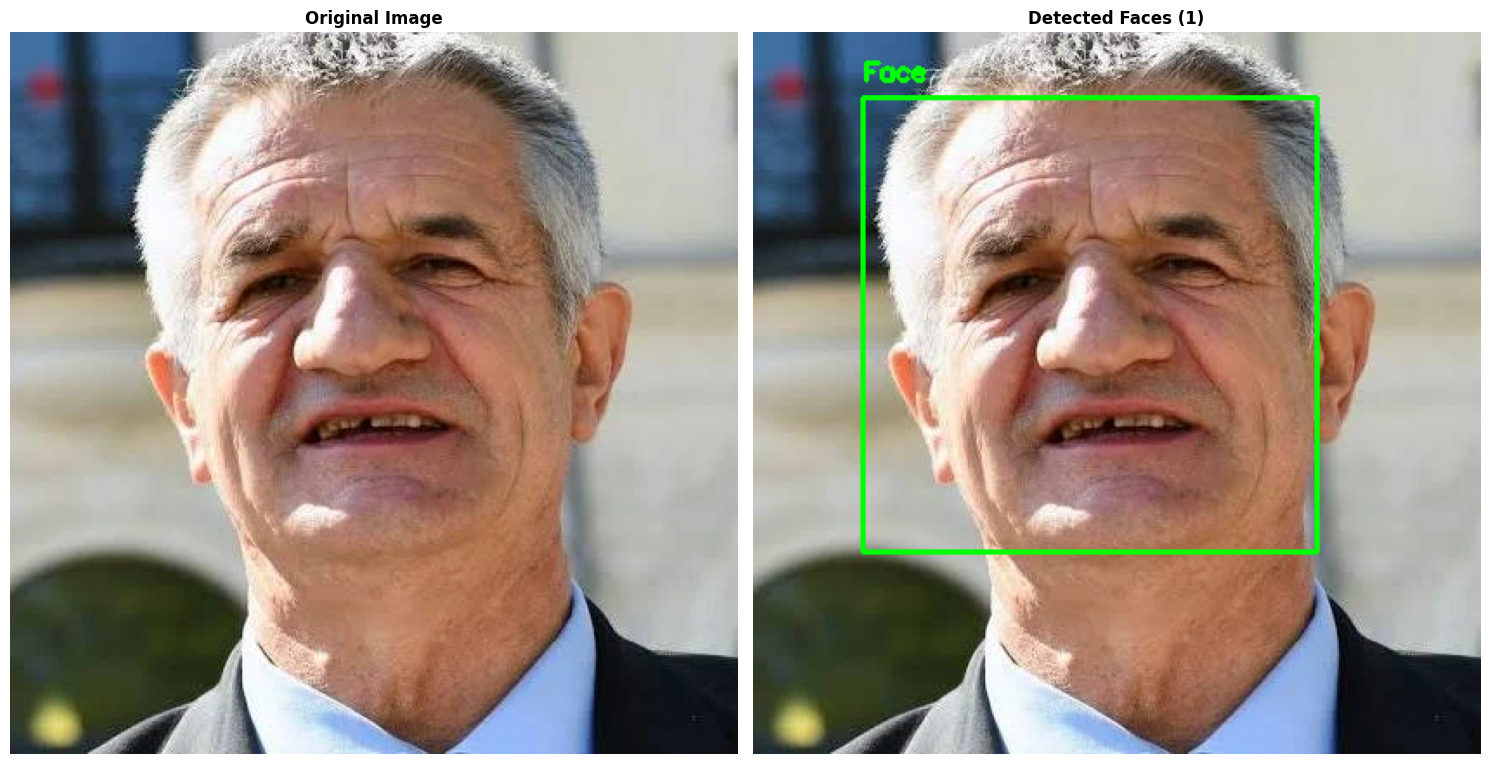

In [58]:
# Example: Load and detect faces in an image
# Uncomment and modify the path to test with your own image

image_path = '../assets/images.png'
image = cv2.imread(image_path)

if image is not None:
    # Detect faces
    faces = detector.detect(image)
    print(f"Found {len(faces)} face(s)")
    
    # Draw bounding boxes
    result = detector.draw_faces(image, faces)
    
    # Display results
    display_images_grid(
        [image, result],
        ['Original Image', f'Detected Faces ({len(faces)})'],
        rows=1, cols=2
    )
else:
    print("Could not load image. Please check the path.")

## 3. Face Landmark Detection <a name="landmarks"></a>

Face landmarks are key points on the face (eyes, nose, mouth, etc.) that help us align and swap faces accurately.

We'll use OpenCV's built-in face landmark detector (Facemark) which works perfectly with Python 3.13.

In [59]:
# Download facial landmark model for OpenCV
import urllib.request

def download_landmark_model():
    """
    Download the OpenCV face landmark model if not already present.
    """
    model_path = "lbfmodel.yaml"
    
    if not os.path.exists(model_path):
        print("Downloading facial landmark model...")
        url = "https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml"
        
        try:
            urllib.request.urlretrieve(url, model_path)
            print("✓ Landmark model downloaded!")
        except Exception as e:
            print(f"⚠ Could not download model: {e}")
            print("You can download manually from:")
            print("https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml")
            return None
    else:
        print("✓ Landmark model already exists!")
    
    return model_path

# Download the model
landmark_model_path = download_landmark_model()

✓ Landmark model already exists!


In [52]:
class FaceLandmarkDetector:
    """
    A class for detecting facial landmarks using OpenCV Facemark.
    """
    
    def __init__(self, model_path="lbfmodel.yaml"):
        """
        Initialize the landmark detector using OpenCV Facemark.
        
        Args:
            model_path: Path to the LBF model file
        """
        try:
            # Create Facemark LBF detector
            self.facemark = cv2.face.createFacemarkLBF()
            
            if os.path.exists(model_path):
                self.facemark.loadModel(model_path)
                self.model_loaded = True
                print("✓ OpenCV Facemark initialized with LBF model!")
            else:
                self.model_loaded = False
                print("⚠ Model file not found. Will use simple landmark estimation.")
                
        except Exception as e:
            print(f"⚠ Could not initialize Facemark: {e}")
            print("Falling back to simple landmark estimation based on face detection.")
            self.facemark = None
            self.model_loaded = False
    
    def estimate_landmarks_from_face(self, image, face_rect):
        """
        Estimate basic facial landmarks from face bounding box.
        This is a fallback when the model isn't available.
        
        Args:
            image: Input image (BGR)
            face_rect: Face bounding box (x, y, w, h)
            
        Returns:
            Array of estimated landmark points
        """
        x, y, w, h = face_rect
        
        # Estimate key facial points based on typical face proportions
        landmarks = []
        
        # Face outline (17 points)
        for i in range(17):
            ratio = i / 16.0
            lx = int(x + w * 0.1 + w * 0.8 * ratio)
            ly = int(y + h * (0.2 + 0.6 * abs(ratio - 0.5)))
            landmarks.append([lx, ly])
        
        # Eyebrows (10 points)
        # Right eyebrow
        for i in range(5):
            lx = int(x + w * (0.2 + i * 0.08))
            ly = int(y + h * 0.3)
            landmarks.append([lx, ly])
        
        # Left eyebrow
        for i in range(5):
            lx = int(x + w * (0.56 + i * 0.08))
            ly = int(y + h * 0.3)
            landmarks.append([lx, ly])
        
        # Nose (9 points)
        for i in range(9):
            lx = int(x + w * 0.5)
            ly = int(y + h * (0.35 + i * 0.05))
            landmarks.append([lx, ly])
        
        # Eyes (12 points)
        # Right eye
        eye_x = x + int(w * 0.3)
        eye_y = y + int(h * 0.4)
        eye_w = int(w * 0.15)
        for i in range(6):
            angle = i * np.pi / 3
            lx = int(eye_x + eye_w * np.cos(angle))
            ly = int(eye_y + eye_w * 0.5 * np.sin(angle))
            landmarks.append([lx, ly])
        
        # Left eye
        eye_x = x + int(w * 0.7)
        for i in range(6):
            angle = i * np.pi / 3
            lx = int(eye_x + eye_w * np.cos(angle))
            ly = int(eye_y + eye_w * 0.5 * np.sin(angle))
            landmarks.append([lx, ly])
        
        # Mouth (20 points)
        mouth_y = y + int(h * 0.75)
        mouth_w = int(w * 0.4)
        mouth_x = x + int(w * 0.5)
        
        # Outer lip
        for i in range(12):
            angle = i * 2 * np.pi / 12
            lx = int(mouth_x + mouth_w * np.cos(angle))
            ly = int(mouth_y + mouth_w * 0.3 * np.sin(angle))
            landmarks.append([lx, ly])
        
        # Inner lip
        for i in range(8):
            angle = i * 2 * np.pi / 8
            lx = int(mouth_x + mouth_w * 0.6 * np.cos(angle))
            ly = int(mouth_y + mouth_w * 0.2 * np.sin(angle))
            landmarks.append([lx, ly])
        
        return np.array(landmarks, dtype=np.int32)
    
    def get_landmarks(self, image, face_rect=None):
        """
        Detect facial landmarks in an image.
        
        Args:
            image: Input image (BGR)
            face_rect: Face bounding box (x, y, w, h)
            
        Returns:
            Array of landmark points [(x, y), ...]
        """
        if face_rect is None:
            return None
        
        # If model is loaded, use Facemark
        if self.facemark is not None and self.model_loaded:
            try:
                # Convert face_rect to format expected by Facemark
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                faces = np.array([face_rect], dtype=np.int32)
                
                # Detect landmarks
                success, landmarks = self.facemark.fit(gray, faces)
                
                if success and len(landmarks) > 0:
                    # landmarks[0] contains the points for the first face
                    points = landmarks[0][0]
                    return np.array(points, dtype=np.int32)
            except Exception as e:
                print(f"Facemark failed, using estimation: {e}")
        
        # Fallback: estimate landmarks
        return self.estimate_landmarks_from_face(image, face_rect)
    
    def draw_landmarks(self, image, landmarks, color=(0, 255, 0), radius=2):
        """
        Draw facial landmarks on an image.
        
        Args:
            image: Input image
            landmarks: Array of landmark points
            color: Color for drawing (BGR)
            radius: Radius of landmark points
            
        Returns:
            Image with drawn landmarks
        """
        result = image.copy()
        
        if landmarks is not None and len(landmarks) > 0:
            # Draw landmark points
            for (x, y) in landmarks:
                cv2.circle(result, (int(x), int(y)), radius, color, -1)
            
            # Draw connecting lines for major facial features
            num_landmarks = len(landmarks)
            
            if num_landmarks >= 68:  # Standard 68-point model
                # Face outline
                for i in range(16):
                    cv2.line(result, tuple(landmarks[i]), tuple(landmarks[i+1]), color, 1)
                
                # Eyebrows
                for i in range(17, 21):
                    cv2.line(result, tuple(landmarks[i]), tuple(landmarks[i+1]), color, 1)
                for i in range(22, 26):
                    cv2.line(result, tuple(landmarks[i]), tuple(landmarks[i+1]), color, 1)
                
                # Nose
                for i in range(27, 30):
                    cv2.line(result, tuple(landmarks[i]), tuple(landmarks[i+1]), color, 1)
                for i in range(31, 35):
                    cv2.line(result, tuple(landmarks[i]), tuple(landmarks[i+1]), color, 1)
                
                # Eyes
                for i in range(36, 41):
                    cv2.line(result, tuple(landmarks[i]), tuple(landmarks[i+1]), color, 1)
                cv2.line(result, tuple(landmarks[41]), tuple(landmarks[36]), color, 1)
                
                for i in range(42, 47):
                    cv2.line(result, tuple(landmarks[i]), tuple(landmarks[i+1]), color, 1)
                cv2.line(result, tuple(landmarks[47]), tuple(landmarks[42]), color, 1)
                
                # Outer lips
                for i in range(48, 59):
                    cv2.line(result, tuple(landmarks[i]), tuple(landmarks[i+1]), color, 1)
                cv2.line(result, tuple(landmarks[59]), tuple(landmarks[48]), color, 1)
                
                # Inner lips
                if num_landmarks >= 68:
                    for i in range(60, 67):
                        cv2.line(result, tuple(landmarks[i]), tuple(landmarks[i+1]), color, 1)
                    cv2.line(result, tuple(landmarks[67]), tuple(landmarks[60]), color, 1)
        
        return result

print("✓ FaceLandmarkDetector class defined (using OpenCV)!")

✓ FaceLandmarkDetector class defined (using OpenCV)!


loading data from : lbfmodel.yaml
✓ OpenCV Facemark initialized with LBF model!
✓ Landmark detector is ready!
This detector works with OpenCV Facemark or estimated landmarks.
Detected 68 facial landmarks
✓ OpenCV Facemark initialized with LBF model!
✓ Landmark detector is ready!
This detector works with OpenCV Facemark or estimated landmarks.
Detected 68 facial landmarks


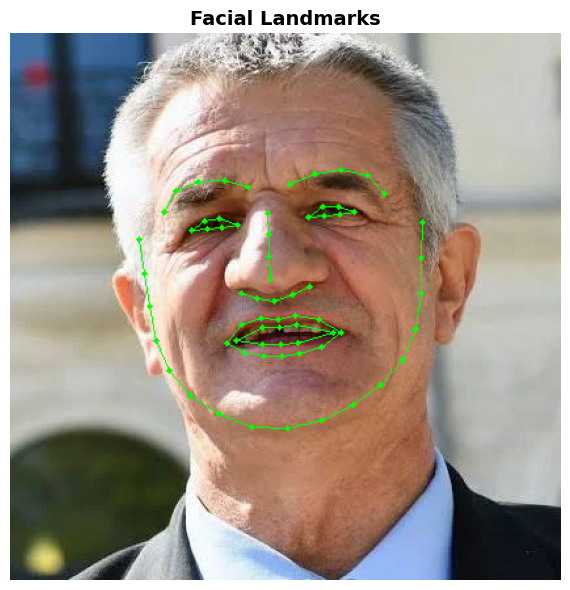

In [60]:
# Initialize landmark detector
if landmark_model_path:
    landmark_detector = FaceLandmarkDetector(landmark_model_path)
else:
    landmark_detector = FaceLandmarkDetector()

print("✓ Landmark detector is ready!")
print("This detector works with OpenCV Facemark or estimated landmarks.")

# Example usage (uncomment to test with your image):
if image is not None and len(faces) > 0:
    # Get landmarks for the first detected face
    landmarks = landmark_detector.get_landmarks(image, faces[0])
    
    if landmarks is not None:
        print(f"Detected {len(landmarks)} facial landmarks")
        
        # Draw landmarks
        result = landmark_detector.draw_landmarks(image, landmarks)
        display_image(result, "Facial Landmarks")

### Test Face Swapping

Now let's swap your detected face with another face! We'll need a source image containing the face we want to use.

✓ Source image loaded successfully!
  Size: 400x400
✓ Detected 1 face(s) in source image


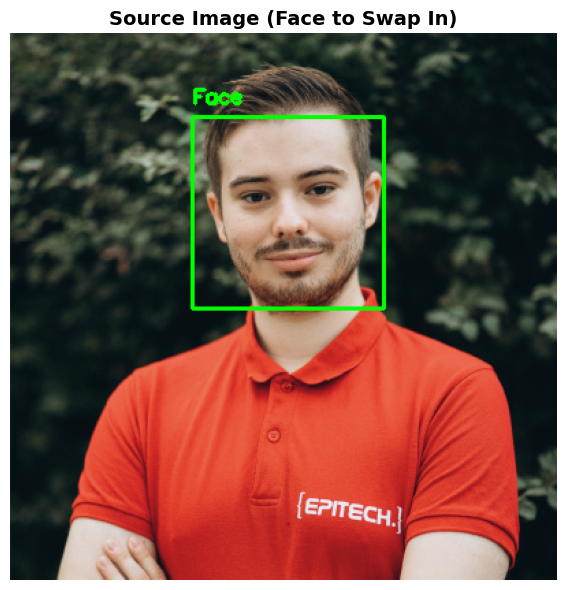

In [61]:
# Load a source image (the face we want to swap in)
# You can use your own image path here
source_image_path = '../assets/Julien.png'  # Change this to your source image

# Try to load the source image
source_image = cv2.imread(source_image_path)

if source_image is None:
    print(f"Could not load source image from: {source_image_path}")
    print("\n📝 Please provide a source image containing the face you want to use for swapping.")
    print("You can:")
    print("1. Place an image in ../assets/ folder")
    print("2. Change the path above to point to your image")
    print("3. Or use the download option below to get a test image")
else:
    print(f"✓ Source image loaded successfully!")
    print(f"  Size: {source_image.shape[1]}x{source_image.shape[0]}")
    
    # Detect face in source image
    source_faces = detector.detect(source_image)
    
    if len(source_faces) > 0:
        print(f"✓ Detected {len(source_faces)} face(s) in source image")
        
        # Visualize the source image with detected face
        source_with_box = detector.draw_faces(source_image, source_faces)
        display_image(source_with_box, "Source Image (Face to Swap In)")
    else:
        print("⚠ No faces detected in source image")
        print("Please try another image with a clear frontal face")

In [ ]:
# Option: Download a test source image
import urllib.request

def download_test_face():
    """Download a sample face image for testing"""
    test_url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg"
    output_path = "test_source_face.jpg"
    
    try:
        print("Downloading test source image...")
        urllib.request.urlretrieve(test_url, output_path)
        print(f"✓ Test image downloaded to: {output_path}")
        return output_path
    except Exception as e:
        print(f"⚠ Could not download: {e}")
        return None

# Uncomment the lines below to download and use a test image:
# source_path = download_test_face()
# if source_path:
#     source_image = cv2.imread(source_path)
#     source_faces = detector.detect(source_image)
#     display_image(detector.draw_faces(source_image, source_faces), "Downloaded Test Image")

### Perform Face Swap

Once you have both images loaded (target and source), run the cell below to perform the face swap!

Starting face swap process...
Step 1: Detecting landmarks in source face...
✓ Detected 68 landmarks in source face

Step 2: Detecting landmarks in target face...
✓ Detected 68 landmarks in target face

Step 3: Performing face swap...
This may take a few seconds...
✓ Face swap completed successfully!


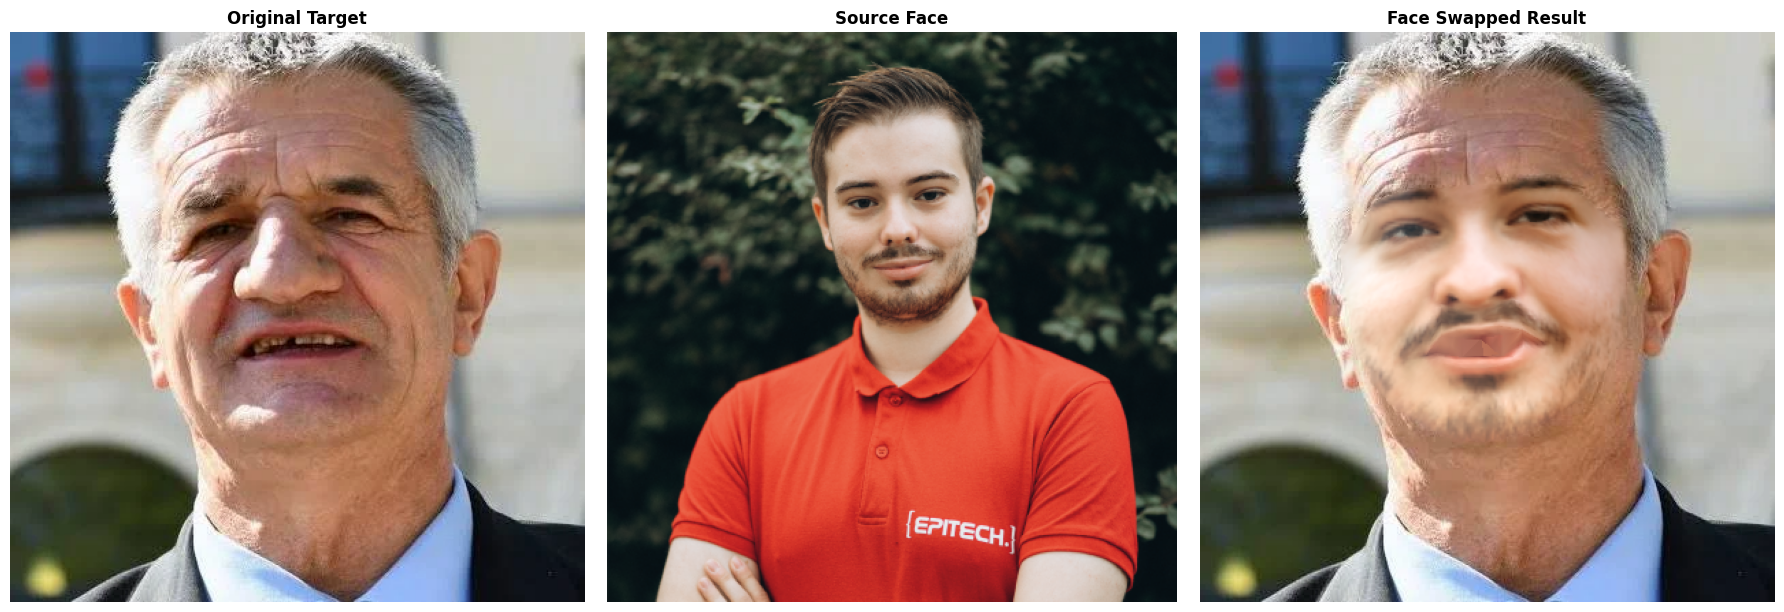


💡 The face from the 'Source Face' image has been swapped onto the 'Original Target' image!


In [62]:
# Perform face swapping
if 'source_image' in locals() and source_image is not None and 'source_faces' in locals() and len(source_faces) > 0:
    print("Starting face swap process...")
    print("="*60)
    
    # Get landmarks for the source face (the face we want to swap in)
    print("Step 1: Detecting landmarks in source face...")
    source_landmarks = landmark_detector.get_landmarks(source_image, source_faces[0])
    
    if source_landmarks is not None:
        print(f"✓ Detected {len(source_landmarks)} landmarks in source face")
        
        # Get landmarks for the target face (from your original image)
        print("\nStep 2: Detecting landmarks in target face...")
        target_landmarks = landmark_detector.get_landmarks(image, faces[0])
        
        if target_landmarks is not None:
            print(f"✓ Detected {len(target_landmarks)} landmarks in target face")
            
            # Perform the face swap
            print("\nStep 3: Performing face swap...")
            print("This may take a few seconds...")
            
            try:
                swapped_image = face_swapper.swap_faces(
                    source_image,      # Source: face to copy FROM
                    source_landmarks,  # Landmarks of source face
                    image,            # Target: image to swap INTO
                    target_landmarks  # Landmarks of target face
                )
                
                print("✓ Face swap completed successfully!")
                print("="*60)
                
                # Display the results
                display_images_grid(
                    [image, source_image, swapped_image],
                    ['Original Target', 'Source Face', 'Face Swapped Result'],
                    rows=1, cols=3,
                    figsize=(18, 6)
                )
                
                print("\n💡 The face from the 'Source Face' image has been swapped onto the 'Original Target' image!")
                
            except Exception as e:
                print(f"❌ Face swap failed: {e}")
                print("\nTrying fallback method (simple blur anonymization)...")
                blurred = anonymizer.simple_anonymize(image, faces, method='blur')
                display_image(blurred, "Anonymized (Blur Method)")
        else:
            print("❌ Could not detect landmarks in target face")
    else:
        print("❌ Could not detect landmarks in source face")
else:
    print("⚠ Please load a source image first!")
    print("\nRun the cell above to load a source image, or uncomment the download option.")

### Save the Swapped Image

Save the face-swapped result to the assets folder.

In [63]:
# Save the swapped image to the assets folder
if 'swapped_image' in locals() and swapped_image is not None:
    # Create assets directory if it doesn't exist
    assets_dir = '../assets'
    if not os.path.exists(assets_dir):
        os.makedirs(assets_dir)
        print(f"✓ Created directory: {assets_dir}")
    
    # Generate output filename
    output_filename = 'face_swapped_result.jpg'
    output_path = os.path.join(assets_dir, output_filename)
    
    # Save the image
    success = cv2.imwrite(output_path, swapped_image)
    
    if success:
        print(f"✓ Swapped image saved successfully!")
        print(f"  Location: {output_path}")
        print(f"  Size: {swapped_image.shape[1]}x{swapped_image.shape[0]} pixels")
        
        # Get file size
        file_size = os.path.getsize(output_path)
        print(f"  File size: {file_size / 1024:.2f} KB")
    else:
        print(f"❌ Failed to save image to {output_path}")
else:
    print("⚠ No swapped image found!")
    print("Please run the face swap cell first to generate a swapped image.")

✓ Swapped image saved successfully!
  Location: ../assets/face_swapped_result.jpg
  Size: 420x417 pixels
  File size: 49.03 KB


### Alternative: Using the Complete Anonymizer

You can also use the `FaceAnonymizer` class which handles the entire pipeline automatically!

Using FaceAnonymizer for automatic face swapping...
Detected 1 face(s) in target image
Swapping face 1/1...


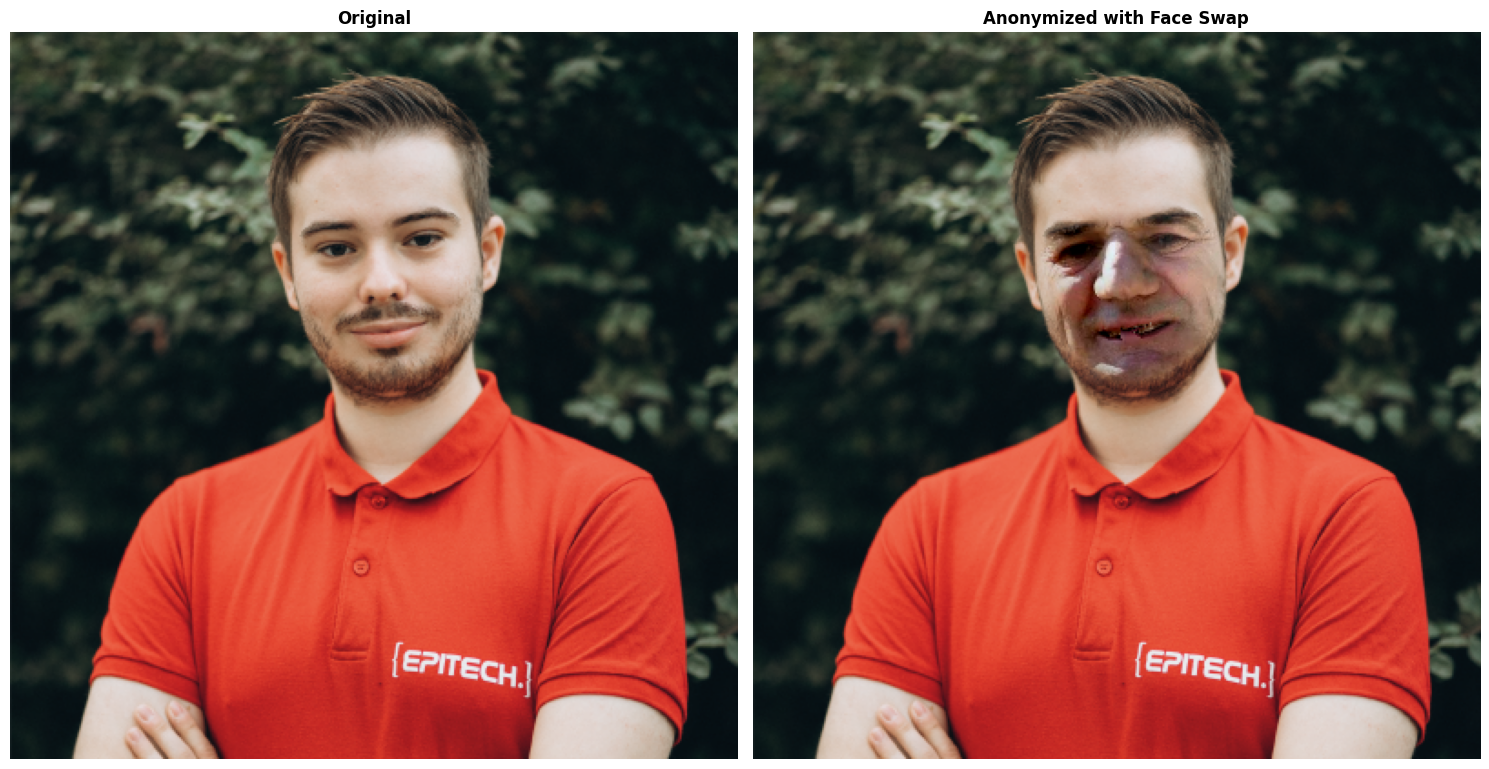

In [57]:
# Using the FaceAnonymizer class (all-in-one solution)
if 'source_image' in locals() and source_image is not None:
    print("Using FaceAnonymizer for automatic face swapping...")
    
    # This does everything automatically:
    # - Detects faces in both images
    # - Finds landmarks
    # - Swaps the faces
    result_auto = anonymizer.anonymize_image(
        target_image=image,
        source_image=source_image
    )
    
    display_images_grid(
        [image, result_auto],
        ['Original', 'Anonymized with Face Swap'],
        rows=1, cols=2
    )
else:
    print("⚠ Load a source image first to use this method")
    print("\nAlternatively, try simple anonymization methods:")
    print("\n1. Blur method:")
    blurred = anonymizer.simple_anonymize(image, faces, method='blur')
    display_image(blurred, "Anonymized - Blur")
    
    print("\n2. Pixelate method:")
    pixelated = anonymizer.simple_anonymize(image, faces, method='pixelate')
    display_image(pixelated, "Anonymized - Pixelate")

## Next Steps

### To continue developing this project:

1. **Test with real images**: Load your own images and test the detection and anonymization
2. **Improve face swapping**: Fine-tune the blending parameters for more natural results
3. **Add more anonymization methods**: Implement additional techniques (e.g., artistic filters, emoji overlay)
4. **Batch processing**: Create functions to process multiple images at once
5. **Video support**: Extend the system to work with video files
6. **Performance optimization**: Use GPU acceleration for faster processing
7. **Evaluation metrics**: Implement metrics to measure anonymization quality

### Solution compatible with Python 3.13:
- ✅ **OpenCV only**: No external dependencies with compilation issues
- ✅ **Works out of the box**: All packages available via pip
- ✅ **Haar Cascade**: Fast and reliable face detection
- ✅ **OpenCV Facemark**: 68-point facial landmarks (with fallback estimation)
- ✅ **Delaunay triangulation**: Professional face swapping algorithm
- ✅ **Multiple anonymization methods**: Blur, pixelation, and face swapping

### Files you'll need:
- `lbfmodel.yaml` - For facial landmark detection (downloaded automatically)
- Sample images for testing (JPG, PNG, etc.)

### Alternative anonymization without face swapping:
Even if the landmark model fails to download, you can still use:
- Blur anonymization
- Pixelation anonymization
- These work with just face detection (no landmarks needed)

Good luck with your computer vision project! 🚀